##      **Insect Detection and Classification using DL**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "insect-village-synthetic" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d vencerlanz09/insect-village-synthetic-dataset
!unzip insect-village-synthetic-dataset.zip -d insect-dataset

Streaming output truncated to the last 5000 lines.
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000000.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000001.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000002.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000003.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000004.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000005.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000006.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000007.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000008.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000009.jpg  
  inflating: insect-dataset/Insect Classes/Insect Classes/Grasshopper/00000010.jpg  
  inflating: i

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv  and test_data.csv file with columns image_path and label for further processing:-


In [3]:
import os
import pandas as pd

# Directories for train and validation datasets
train_dir = '/content/insect-dataset/Insect Classes/Insect Classes'

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Function to process each directory (train or valid)
def process_directory(directory, label_list, path_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):
                    image_path = os.path.join(label_dir, image_name)
                    path_list.append(image_path)
                    label_list.append(label)

# Process the train and valid directories
process_directory(train_dir, labels, image_paths)

# Create DataFrame and save to CSV
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

csv_file_path = '/content/insect-dataset/train_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV file for train and valid folders saved successfully!")

CSV file for train and valid folders saved successfully!


In [4]:
import os
import pandas as pd

# Directory for test dataset
test_dir = '/content/insect-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw'

# Initialize lists to hold image paths and labels
test_image_paths = []
test_labels = []

# Function to recursively process the test directory
def process_test_directory(directory, label_list, path_list):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                path_list.append(image_path)
                label_list.append("Unknown")

# Process the test directory
process_test_directory(test_dir, test_labels, test_image_paths)

# Create DataFrame and save to CSV
test_data = {'Image_Path': test_image_paths, 'Label': test_labels}
test_df = pd.DataFrame(test_data)

test_csv_file_path = '/content/insect-dataset/test_data.csv'
test_df.to_csv(test_csv_file_path, index=False)

print("CSV file for test folder saved successfully!")

CSV file for test folder saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , InceptionV3 and ResNet50V2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception  , DenseNet121 , ResNet101V2 , ResNet50V2  , InceptionV3
from keras import layers, models, optimizers

# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/insect-dataset/train_data.csv')

# Identify the label column name in your dataset
label_column = 'Label'

# Split the data ensuring equal representation of labels in train and valid sets
train_df, val_df = train_test_split(df, train_size=0.9, test_size=0.1, random_state=42, stratify=df[label_column])

# Check the number of unique labels in both sets
train_unique_labels = train_df[label_column].nunique()
val_unique_labels = val_df[label_column].nunique()
num_classes = len(df['Label'].unique())
print(f"Number of unique labels in training set: {train_unique_labels}")
print(f"Number of unique labels in validation set: {val_unique_labels}")

Number of unique labels in training set: 10
Number of unique labels in validation set: 10


In [7]:
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

In [8]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 9000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


# Exploratory Data Analysis

In [9]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                             Image_Path      Label
6726  /content/insect-dataset/Insect Classes/Insect ...      Snail
7074  /content/insect-dataset/Insect Classes/Insect ...  Butterfly
9604  /content/insect-dataset/Insect Classes/Insect ...   Scorpion
8111  /content/insect-dataset/Insect Classes/Insect ...     Spider
6824  /content/insect-dataset/Insect Classes/Insect ...      Snail
(9000, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 6726 to 8184
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  9000 non-null   object
 1   Label       9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB
None
                                               Image_Path  Label
count                                                9000   9000
unique                                               9000     10
top     /content/insect-dataset/Insect Classes/Insect ...  Snail
freq             

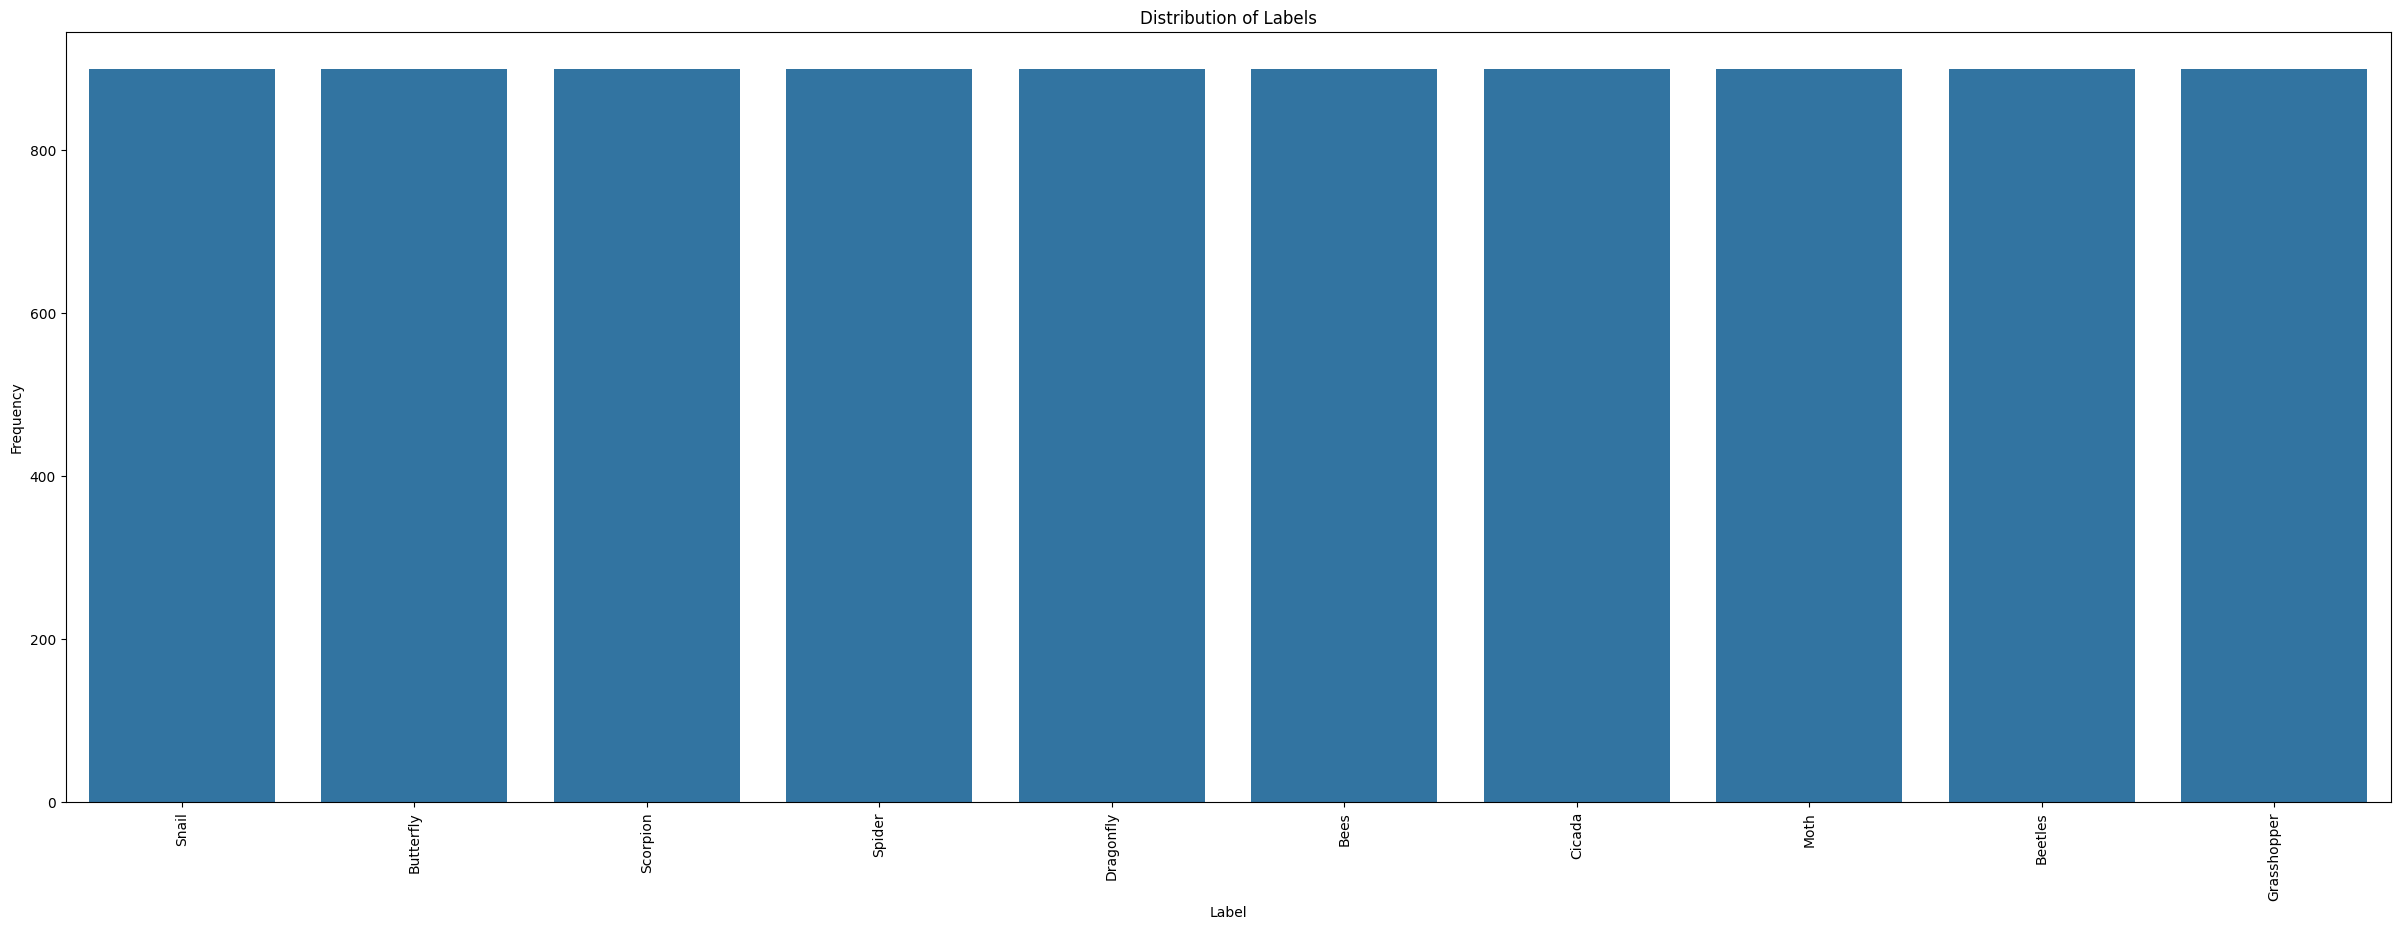

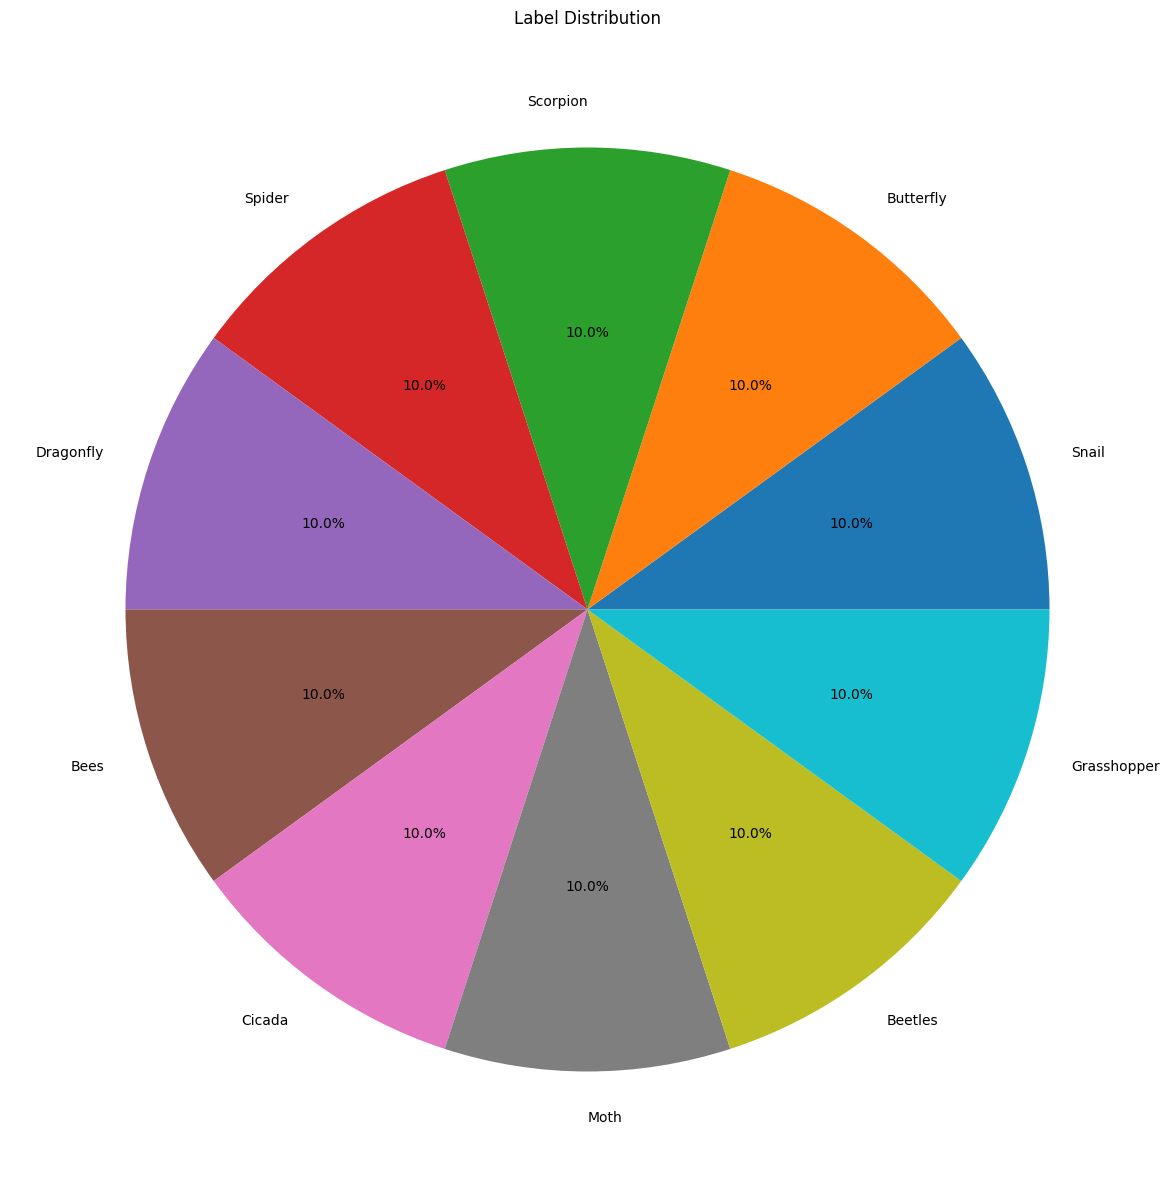

In [10]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

Number of unique image paths: 9000


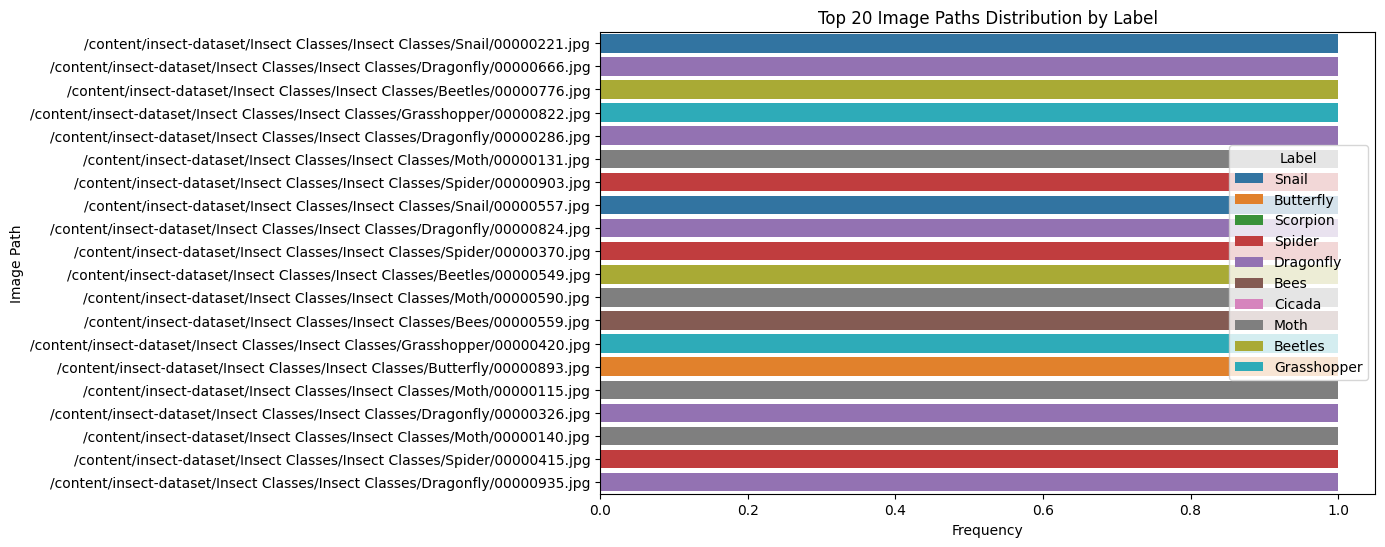

Column Image_Path has 9000 unique values.
Column Label has 10 unique values.


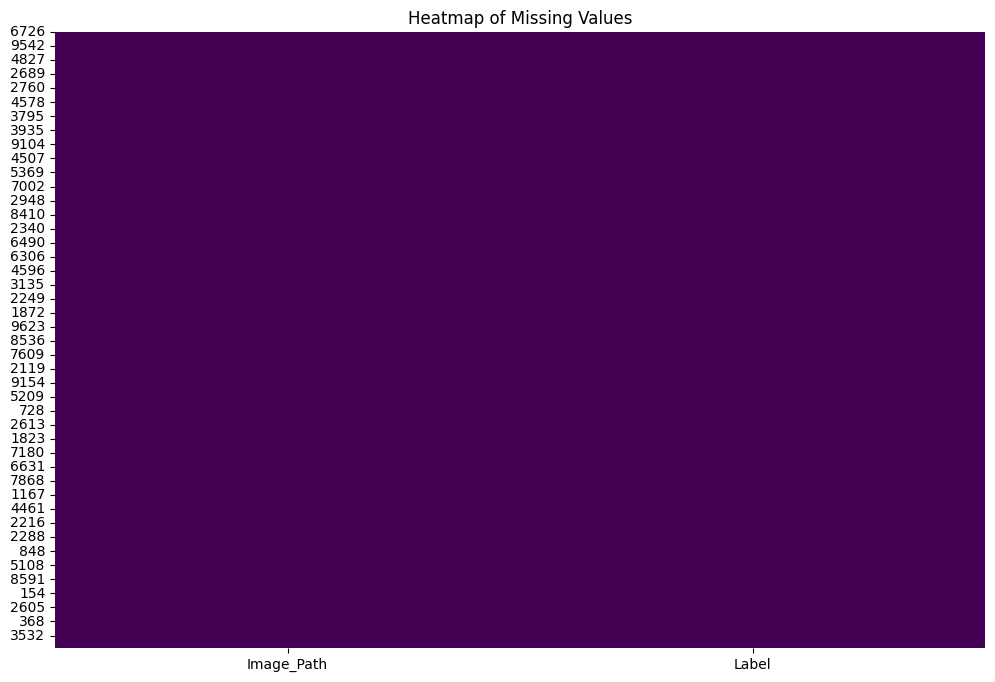

Label
Snail          900
Butterfly      900
Scorpion       900
Spider         900
Dragonfly      900
Bees           900
Cicada         900
Moth           900
Beetles        900
Grasshopper    900
Name: count, dtype: int64


In [ ]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [ ]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Label         0
dtype: int64
0


# Customizing model according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [11]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D

from keras.layers import Dropout

def create_model(base_model, input_shape, num_classes):
    base_model.trainable = True  # Unfreeze the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [12]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the specified number of epochs
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(train_data),
                        epochs=epochs,
                        callbacks=[early_stopping])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Get the true labels and predictions
    val_data.reset()  # Reset the generator
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    plt.figure(figsize=(12, 7))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history

In [13]:
def model_training (base_models):
  # Directory to save the models
  save_dir = 'saved_models'
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  # Adjustments for ResNet50
  # Train and evaluate each model
  histories = {}
  for base_model, input_shape, model_name in base_models:
      # Resize data if necessary (dummy data, so not applicable here)
      if input_shape != (224, 224, 3):
          # Resize X_train and X_val to the required input_shape
          # This is just a placeholder, implement actual resizing if needed
          pass

      # Create the model
      model = create_model(base_model, input_shape, num_classes)

      if model_name == 'ResNet50':
          # Unfreeze more layers for ResNet50 and adjust learning rate
          for layer in model.layers[-30:]:
              layer.trainable = True
          epochs = 10
          optimizer = optimizers.Adam(learning_rate=0.0001)
      else:
          epochs = 10
          optimizer = optimizers.Adam()

      # Compile the model
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

      print(f'Training {model_name}...')
      history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=epochs)
      histories[model_name] = history

      # Saving the model after training
      model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
      print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

171317808/171317808 [==============================] - 3s 0us/step
Training ResNet101V2...
Epoch 1/10
282/282 [==============================] - 256s 674ms/step - loss: 1.3157 - accuracy: 0.5558 - val_loss: 0.7009 - val_accuracy: 0.7930
Epoch 2/10
282/282 [==============================] - 186s 657ms/step - loss: 0.4914 - accuracy: 0.8592 - val_loss: 0.3301 - val_accuracy: 0.9010
Epoch 3/10
282/282 [==============================] - 187s 663ms/step - loss: 0.3395 - accuracy: 0.9061 - val_loss: 0.3401 - val_accuracy: 0.9110
Epoch 4/10
282/282 [==============================] - 190s 672ms/step - loss: 0.2819 - accuracy: 0.9214 - val_loss: 0.6170 - val_accuracy: 0.8480
Epoch 5/10
282/282 [==============================] - 187s 662ms/step - loss: 0.2492 - accuracy: 0.9322 - val_loss: 0.3657 - val_accuracy: 0.8970
Epoch 6/10
282/282 [==============================] - 187s 664ms/step - loss: 0.2132 - accuracy: 0.9452 - val_loss: 0.3498 - val_accuracy: 0.9100
Epoch 7/10
32/32 [===============

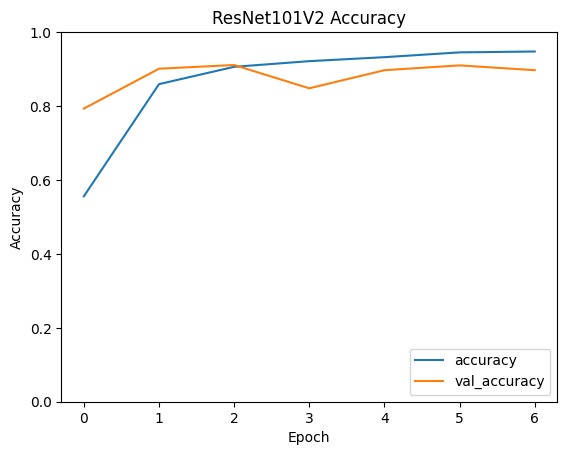

32/32 [==============================] - 7s 158ms/step


<Figure size 1200x700 with 0 Axes>

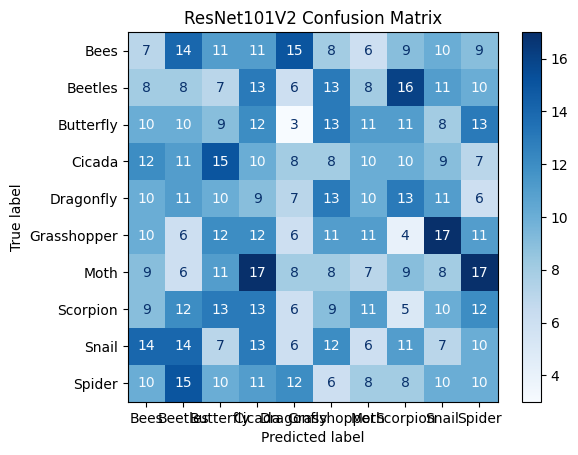

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet101V2 model to saved_models/ResNet101V2_saved.h5


In [14]:
# List of base models with their respective input shapes
base_models1 = [
    (ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3),'ResNet101V2'),
]
model_training (base_models1)

87910968/87910968 [==============================] - 0s 0us/step
Training InceptionV3...
Epoch 1/10
282/282 [==============================] - 199s 568ms/step - loss: 1.2180 - accuracy: 0.5928 - val_loss: 0.3627 - val_accuracy: 0.8990
Epoch 2/10
282/282 [==============================] - 152s 538ms/step - loss: 0.4067 - accuracy: 0.8798 - val_loss: 0.3910 - val_accuracy: 0.8900
Epoch 3/10
282/282 [==============================] - 147s 521ms/step - loss: 0.2484 - accuracy: 0.9299 - val_loss: 0.2422 - val_accuracy: 0.9360
Epoch 4/10
282/282 [==============================] - 148s 525ms/step - loss: 0.1966 - accuracy: 0.9467 - val_loss: 0.2363 - val_accuracy: 0.9410
Epoch 5/10
282/282 [==============================] - 151s 533ms/step - loss: 0.1755 - accuracy: 0.9520 - val_loss: 0.3186 - val_accuracy: 0.9130
Epoch 6/10
282/282 [==============================] - 149s 526ms/step - loss: 0.1644 - accuracy: 0.9556 - val_loss: 0.2167 - val_accuracy: 0.9450
Epoch 7/10
282/282 [===============

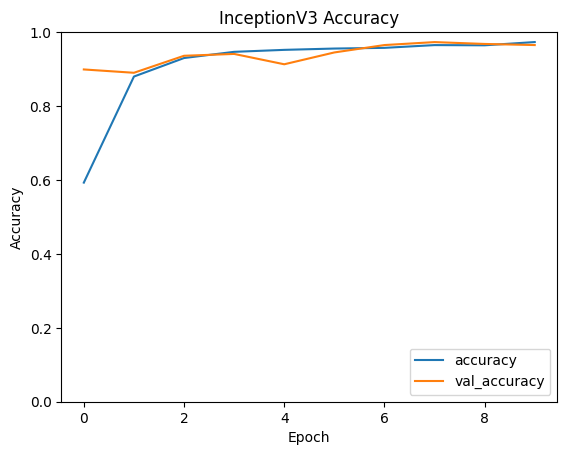

32/32 [==============================] - 5s 87ms/step


<Figure size 1200x700 with 0 Axes>

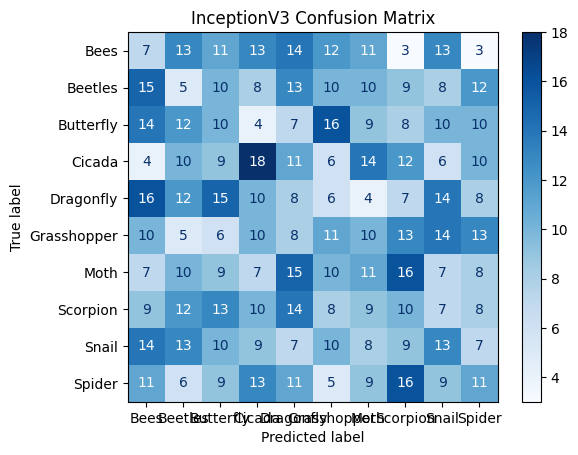

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


In [15]:
base_models2 = [
  (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'InceptionV3')
]
model_training (base_models2)

83683744/83683744 [==============================] - 1s 0us/step
Training Xception...
Epoch 1/10
282/282 [==============================] - 217s 655ms/step - loss: 1.2000 - accuracy: 0.5960 - val_loss: 0.2672 - val_accuracy: 0.9120
Epoch 2/10
282/282 [==============================] - 180s 637ms/step - loss: 0.3153 - accuracy: 0.9074 - val_loss: 0.1906 - val_accuracy: 0.9410
Epoch 3/10
282/282 [==============================] - 179s 633ms/step - loss: 0.1900 - accuracy: 0.9471 - val_loss: 0.1582 - val_accuracy: 0.9500
Epoch 4/10
282/282 [==============================] - 180s 636ms/step - loss: 0.1403 - accuracy: 0.9614 - val_loss: 0.1318 - val_accuracy: 0.9610
Epoch 5/10
282/282 [==============================] - 181s 641ms/step - loss: 0.1200 - accuracy: 0.9671 - val_loss: 0.1331 - val_accuracy: 0.9600
Epoch 6/10
282/282 [==============================] - 182s 644ms/step - loss: 0.0872 - accuracy: 0.9744 - val_loss: 0.1433 - val_accuracy: 0.9560
Epoch 7/10
282/282 [==================

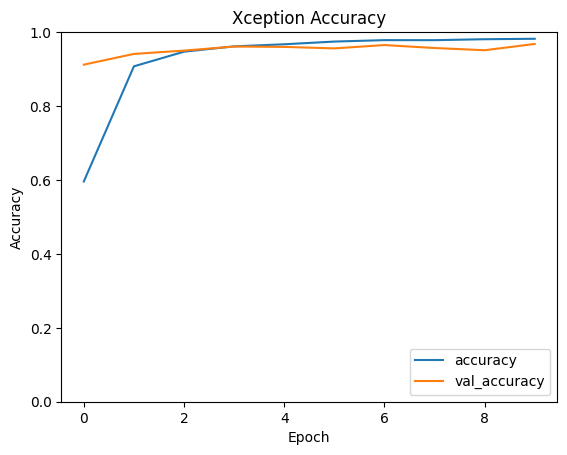

32/32 [==============================] - 5s 137ms/step


<Figure size 1200x700 with 0 Axes>

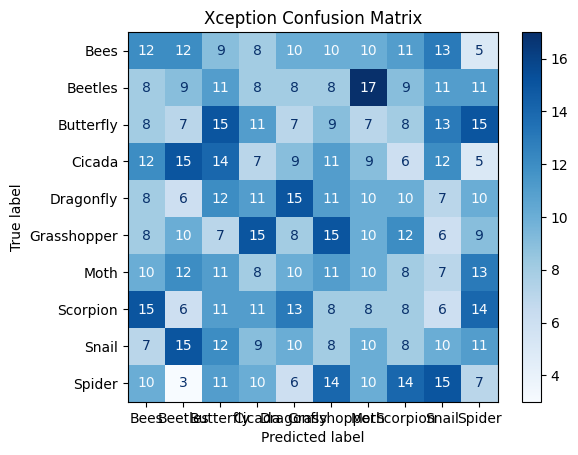

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved Xception model to saved_models/Xception_saved.h5


In [16]:
base_models3 = [
  (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]
model_training (base_models3)

94668760/94668760 [==============================] - 1s 0us/step
Training ResNet50V2...
Epoch 1/10
282/282 [==============================] - 186s 561ms/step - loss: 1.3280 - accuracy: 0.5607 - val_loss: 0.8096 - val_accuracy: 0.7730
Epoch 2/10
282/282 [==============================] - 153s 541ms/step - loss: 0.5113 - accuracy: 0.8516 - val_loss: 0.4548 - val_accuracy: 0.8790
Epoch 3/10
282/282 [==============================] - 156s 553ms/step - loss: 0.3632 - accuracy: 0.8939 - val_loss: 0.3387 - val_accuracy: 0.8980
Epoch 4/10
282/282 [==============================] - 154s 547ms/step - loss: 0.2995 - accuracy: 0.9149 - val_loss: 0.2438 - val_accuracy: 0.9230
Epoch 5/10
282/282 [==============================] - 159s 563ms/step - loss: 0.2490 - accuracy: 0.9289 - val_loss: 0.2466 - val_accuracy: 0.9370
Epoch 6/10
282/282 [==============================] - 155s 549ms/step - loss: 0.2197 - accuracy: 0.9356 - val_loss: 0.3572 - val_accuracy: 0.8830
Epoch 7/10
282/282 [================

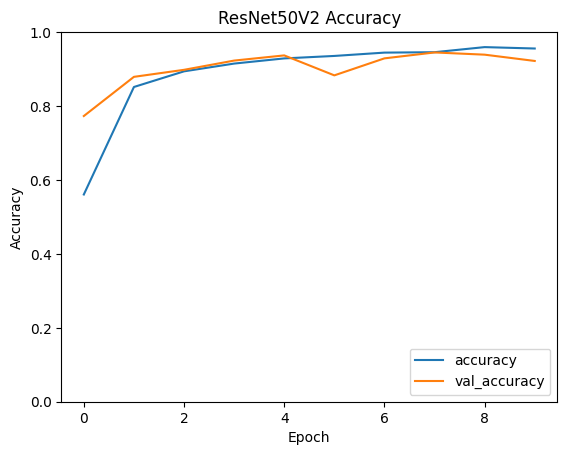

32/32 [==============================] - 4s 88ms/step


<Figure size 1200x700 with 0 Axes>

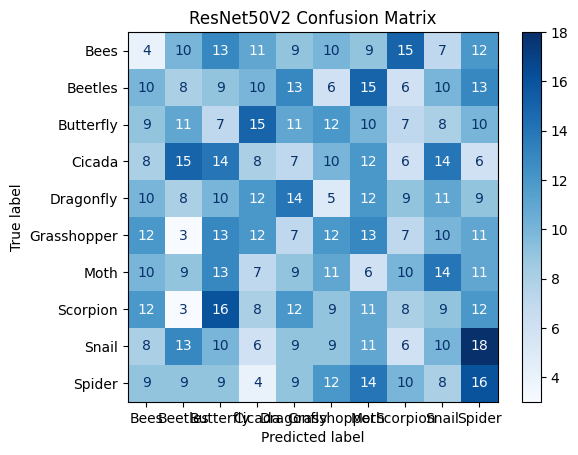

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


In [17]:
base_models4 = [
  (ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50V2')
]
model_training (base_models4)

29084464/29084464 [==============================] - 0s 0us/step
Training DenseNet121...
Epoch 1/10
282/282 [==============================] - 247s 606ms/step - loss: 1.1023 - accuracy: 0.6429 - val_loss: 0.2471 - val_accuracy: 0.9180
Epoch 2/10
282/282 [==============================] - 163s 577ms/step - loss: 0.2658 - accuracy: 0.9237 - val_loss: 0.3270 - val_accuracy: 0.9000
Epoch 3/10
282/282 [==============================] - 162s 574ms/step - loss: 0.1599 - accuracy: 0.9541 - val_loss: 0.2151 - val_accuracy: 0.9420
Epoch 4/10
282/282 [==============================] - 162s 572ms/step - loss: 0.1249 - accuracy: 0.9640 - val_loss: 0.6724 - val_accuracy: 0.8590
Epoch 5/10
282/282 [==============================] - 165s 582ms/step - loss: 0.0972 - accuracy: 0.9722 - val_loss: 0.2721 - val_accuracy: 0.9210
Epoch 6/10
282/282 [==============================] - 162s 575ms/step - loss: 0.0894 - accuracy: 0.9741 - val_loss: 0.2725 - val_accuracy: 0.9360
Epoch 7/10
282/282 [===============

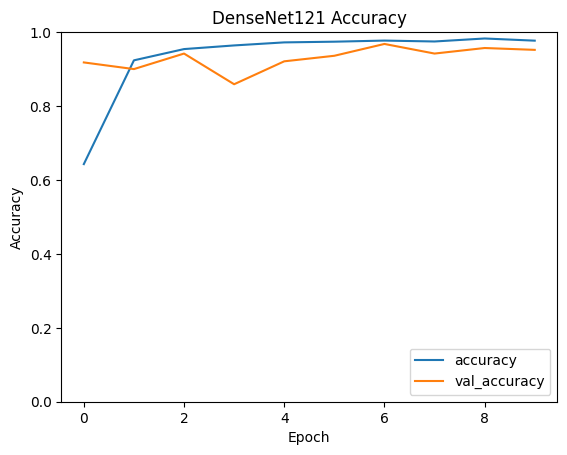

32/32 [==============================] - 6s 105ms/step


<Figure size 1200x700 with 0 Axes>

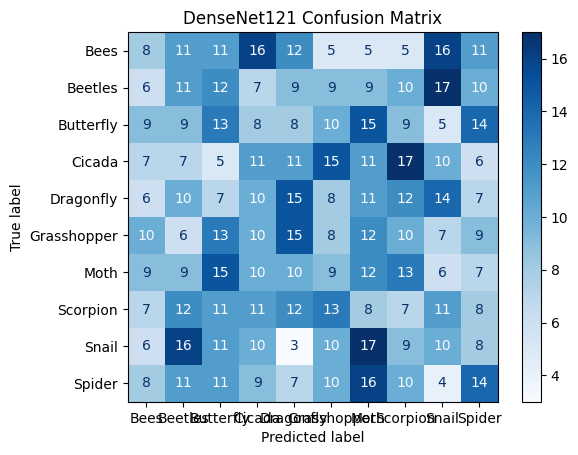

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


In [18]:
# List of base models with their respective input shapes
base_models5 = [
   (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet121')
]
model_training (base_models5)

# Testing and labeling unseen data

In [19]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image

# Load test dataset
test_df = pd.read_csv('/content/insect-dataset/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file or "InceptionV3_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'Label': prediction_labels,
        })

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")

1/1 [==============================] - 4s 4s/step
Predictions saved to /content/saved_models/predicted_ResNet101V2_saved.csv
1/1 [==============================] - 6s 6s/step
Predictions saved to /content/saved_models/predicted_InceptionV3_saved.csv
1/1 [==============================] - 5s 5s/step
Predictions saved to /content/saved_models/predicted_Xception_saved.csv
1/1 [==============================] - 1s 835ms/step
Predictions saved to /content/saved_models/predicted_ResNet50V2_saved.csv
1/1 [==============================] - 6s 6s/step
Predictions saved to /content/saved_models/predicted_DenseNet121_saved.csv


# image label and prediction and visualization

Predictions using: predicted_DenseNet121_saved


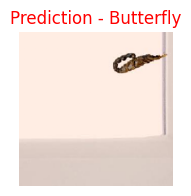

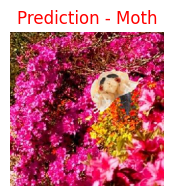

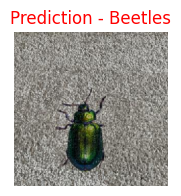

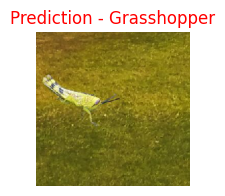

Predictions using: predicted_InceptionV3_saved


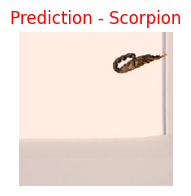

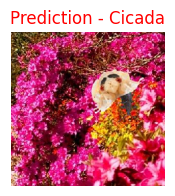

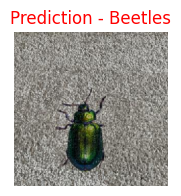

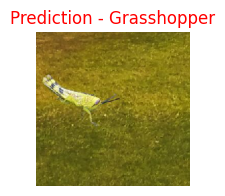

Predictions using: predicted_ResNet101V2_saved


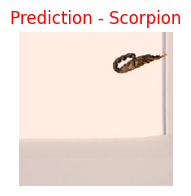

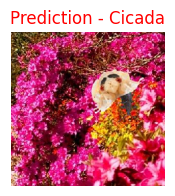

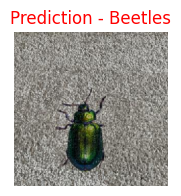

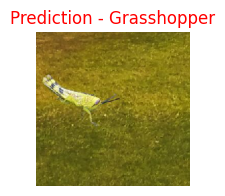

Predictions using: predicted_ResNet50V2_saved


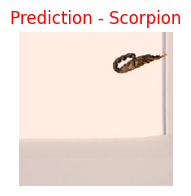

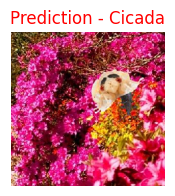

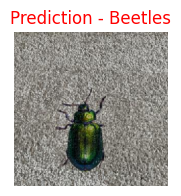

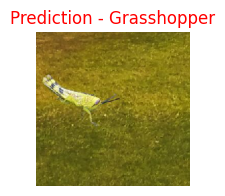

Predictions using: predicted_Xception_saved


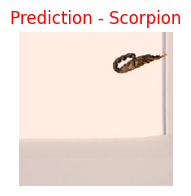

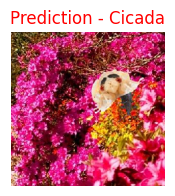

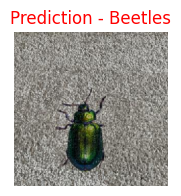

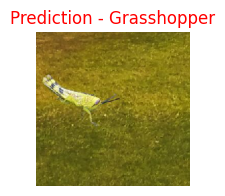

In [20]:
import csv
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/insect-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00004481.jpg',
    '/content/insect-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00010709.jpg',
    '/content/insect-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00009691.jpg',
    '/content/insect-dataset/ImageClassesCombinedWithCOCOAnnotations/images_raw/00013954.jpg'
]

def load_predicted_labels(csv_file_path):
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Label']
    return predicted_labels

def visualize_predictions(filenames, predicted_labels):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_name = predicted_labels[filename]
        else:
            print(f"Filename not found: {filename}")
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Directory containing the predicted CSV files
csv_dir = '/content/saved_models'

# Iterate over each CSV file in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):
        # Determine the model name
        model_name = csv_file.split('.')[0]

        # Path to the CSV file containing predictions for the current model
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        # Load predicted labels from the CSV file
        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Predict and plot images using predicted labels
        print(f"Predictions using: {model_name}")
        visualize_predictions(filenames, predicted_labels)
